# Tangles-CNN Training Notebook

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
from PIL import Image
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


In [2]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models
from unet_wildcat import *

In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
exp_dir = "/home/pyushkevich/data/dirwin/dlb/organize/exp01_dlb"
data_dir = os.path.join(exp_dir, "patches")

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 30

# Input image size
input_size = 224

In [4]:
# Or use their initialization method
model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.02, kmin=0.0, alpha=0.7, num_maps=4)
# model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.05, kmin=0.02, alpha=0.5, num_maps=2)

In [5]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-2)

# Transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

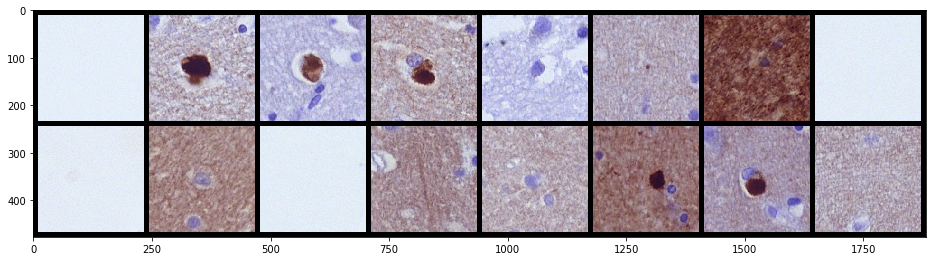

In [6]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

In [7]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [8]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history




In [9]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=50)





Epoch 0/49
----------


/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train Loss: 0.4262 Acc: 0.8830
val Loss: 0.3129 Acc: 0.9348

Epoch 1/49
----------
train Loss: 0.2226 Acc: 0.9335
val Loss: 0.0998 Acc: 0.9925

Epoch 2/49
----------
train Loss: 0.1865 Acc: 0.9511
val Loss: 0.1000 Acc: 0.9925

Epoch 3/49
----------
train Loss: 0.1542 Acc: 0.9575
val Loss: 0.1749 Acc: 0.9248

Epoch 4/49
----------
train Loss: 0.1268 Acc: 0.9688
val Loss: 0.0629 Acc: 0.9925

Epoch 5/49
----------
train Loss: 0.1564 Acc: 0.9599
val Loss: 0.0524 Acc: 0.9925

Epoch 6/49
----------
train Loss: 0.1198 Acc: 0.9696
val Loss: 0.0797 Acc: 0.9875

Epoch 7/49
----------
train Loss: 0.1013 Acc: 0.9768
val Loss: 0.0661 Acc: 0.9925

Epoch 8/49
----------
train Loss: 0.1091 Acc: 0.9720
val Loss: 0.1197 Acc: 0.9649

Epoch 9/49
----------
train Loss: 0.1192 Acc: 0.9696
val Loss: 0.0730 Acc: 0.9900

Epoch 10/49
----------
train Loss: 0.1074 Acc: 0.9704
val Loss: 0.0910 Acc: 0.9774

Epoch 11/49
----------
train Loss: 0.1188 Acc: 0.9663
val Loss: 0.0483 Acc: 0.9950

Epoch 12/49
----------
t

In [10]:
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)
torch.save(model_ft.state_dict(),os.path.join(model_dir, "my_wildcat_50_30epoch_k02_upsample.dat"))

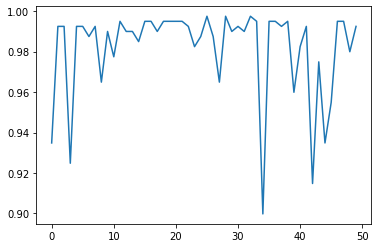

In [11]:
plt.plot(hist)

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Tue Aug  4 09:36:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    42W / 250W |   2077MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------